In [ ]:
# RRank v05
# ML Prediction for Reliability Rank

In [1]:
# Load libraries

import pandas as pd
import numpy as np
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score,)

le = preprocessing.LabelEncoder()

In [2]:
# Set the max rows and columns for easier data previews

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

In [3]:
# load raw files into dataframes

df_positions_raw = pd.read_csv(r"c:\Users\rapelak\RRank\RRANK_POSITIONS_13SEP2023.csv")
df_correctives_raw = pd.read_csv(r"c:\Users\rapelak\RRank\RRANK_CORWO_01SEP2018_01SEP2023.csv")
df_pms_raw = pd.read_csv(r"c:\Users\rapelak\RRank\RRANK_PM_13SEP2023.csv")

In [4]:
# build a working position dataframe
df_positions_working = df_positions_raw

# clean up the working position dataframe
# drop redundant rows with a parent of "L"
df_positions_working = df_positions_working.drop(df_positions_working[df_positions_working['Parent Type'] == 'L'].index)
# set the index as the object
df_positions_working = df_positions_working.set_index('Object')
# eleiminate any duplicate rows that snuck in to the data
df_positions_working = df_positions_working[~df_positions_working.index.duplicated(keep='first')]

# Drop unnecessary columns
df_positions_working = df_positions_working.drop(columns = ['Object Org.', 'Type', 'Status', 'Description', 'Location', 'Object Legacy ID', 'Obj. Leg. ID #4', 'P&ID drawing'])
# convert boolean columns to yes/no
## note - pluses and minuses seem to be preceded by a space
df_positions_working['Production'] = df_positions_working['Production'].map({' +':1, ' -':0})
df_positions_working['Production'] = df_positions_working['Production'].astype(int)
df_positions_working['EHS-Regulatory'] = df_positions_working['EHS-Regulatory'].map({' +':1, ' -':0})
df_positions_working['EHS-Regulatory'] = df_positions_working['EHS-Regulatory'].astype(int)
df_positions_working['GxP'] = df_positions_working['GxP'].map({' +':1, ' -':0})
df_positions_working['GxP'] = df_positions_working['GxP'].astype(int)
df_positions_working['P&ID No'] = df_positions_working['P&ID No'].fillna(0)
df_positions_working.loc[df_positions_working['P&ID No'] != 0, 'P&ID No'] = 1
df_positions_working['P&ID No'] = df_positions_working['P&ID No'].astype(int)
# convert commission date from string to datetime
df_positions_working['Commission Date'] = pd.to_datetime(df_positions_working['Commission Date'])
# convert integer field Department to object
df_positions_working['Department'] = df_positions_working['Department'].apply(str)
# rename columns to eliminate spaces and special characters
df_positions_working = df_positions_working.rename(columns = {'Parent Type': 'ParentType', 'EHS-Regulatory':'EHS', 'Obj. Leg. ID #1':'LegID1', 'Obj. Leg. ID # 2':'LegID2', 'Obj. Leg. ID # 3':'LegID3', 'Commission Date': 'CommissionDate', 'P&ID No': "PID", 'Reliability Ranking':'oRRank'})

# add an age column representing how many days of the 5-year window the equipment was in operation
df_positions_working['age'] = dt.datetime(2023,9,1) - df_positions_working['CommissionDate']
df_positions_working['age'] = df_positions_working['age'].dt.days
df_positions_working['age'] = np.where(df_positions_working['age'] > 1825, 1825, df_positions_working['age'])
# put the age roughly into years so that it is more intuitive when used as a denominator
df_positions_working['age'] = df_positions_working['age'] / 365
# remove the commission date now that we are done with it
df_positions_working = df_positions_working.drop(columns = ['CommissionDate'])

# combine class + category into one column to avoid dependent features
df_positions_working['classCat'] = df_positions_working['Class'] + df_positions_working['Category']
df_positions_working = df_positions_working.drop(columns = ['Class', 'Category'])

# combine LegID1 + legID3 to represent location in process & drop Dept and LegID2, again to avoid dependency
df_positions_working['process'] = df_positions_working['LegID1'] + df_positions_working['LegID3']
df_positions_working = df_positions_working.drop(columns = ['LegID1', 'LegID3', 'LegID2', 'Department'])

# drop model to avoid dependancy with manufacturer
## don't combine it - it is too inconsistantly written, and often mis-spelled
df_positions_working = df_positions_working.drop(columns = ['Model'])
## might need to do some cleanup here to combine similar Manufacturers with slightly different spellings

df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,age,classCat,process
Object,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,MICRO MOTION INC,CLS04,1,0,1,1,SILVER,5.000000,METERM-FLOWMETER,P335TK360
066MTPH9500-2,NaN,S,FISHER SCIENTIFIC CO,CLS03,1,0,1,0,NaN,0.731507,METERM-PHMETER,P066IPL LAB
335COND0340-1-XV-055,335COND0340-1,P,ATOMAC,CLS04,1,0,1,1,LEAD,5.000000,INSTINSTOTH,P335TK340
335COND0340-1-XV-056,335COND0340-1,P,ATOMAC,CLS04,1,0,1,1,LEAD,5.000000,INSTINSTOTH,P335TK340
073FSVS1820-1,073TANK1820-1,P,ASSURED AUTOMATION,CLS05,1,1,0,1,NaN,0.728767,SYSTFIREFIRESV,P073DIKE-B


In [5]:
# manually encode the outcome (reliability rank)
## prefer this to be in order and easily relatable
## need to get fields to an integer for use in NB model
## NaNs get assigned a value of 0

# encode the reliability rank field
dict_map_RRank = {0: 'blank', 1: 'LEAD', 2: 'BRONZE', 3: 'SILVER', 4: 'GOLD', 5: 'PLATINUM'}
list_condition = [df_positions_working['oRRank'].isnull(), df_positions_working['oRRank'] == 'LEAD', df_positions_working['oRRank'] == 'BRONZE', df_positions_working['oRRank'] == 'SILVER', df_positions_working['oRRank'] == 'GOLD', df_positions_working['oRRank'] == 'PLATINUM']
list_choice = [0, 1, 2, 3, 4, 5]
df_positions_working['oRRank'] = np.select(list_condition, list_choice, default = 0)
df_positions_working['oRRank'] = df_positions_working['oRRank'].astype('int32')


df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,age,classCat,process
Object,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,MICRO MOTION INC,CLS04,1,0,1,1,3,5.000000,METERM-FLOWMETER,P335TK360
066MTPH9500-2,NaN,S,FISHER SCIENTIFIC CO,CLS03,1,0,1,0,0,0.731507,METERM-PHMETER,P066IPL LAB
335COND0340-1-XV-055,335COND0340-1,P,ATOMAC,CLS04,1,0,1,1,1,5.000000,INSTINSTOTH,P335TK340
335COND0340-1-XV-056,335COND0340-1,P,ATOMAC,CLS04,1,0,1,1,1,5.000000,INSTINSTOTH,P335TK340
073FSVS1820-1,073TANK1820-1,P,ASSURED AUTOMATION,CLS05,1,1,0,1,0,0.728767,SYSTFIREFIRESV,P073DIKE-B


In [6]:
# encode the large choice columns with generated relationships
## need to get fields to an integer for use in NB model
## NaNs get assigned a value from the algortihm, see dict for it

# encode classCat
encode = le.fit_transform(df_positions_working['classCat'])
dict_map_class = {l: i for i, l in enumerate(le.classes_)}
df_positions_working['classCat'] = encode

# encode critcality
encode = le.fit_transform(df_positions_working['Criticality'])
dict_map_criticality = {l: i for i, l in enumerate(le.classes_)}
df_positions_working['Criticality'] = encode

# encode manufacturer
encode = le.fit_transform(df_positions_working['Manufacturer'])
dict_map_manufacturer = {l: i for i, l in enumerate(le.classes_)}
df_positions_working['Manufacturer'] = encode

# encode department
encode = le.fit_transform(df_positions_working['process'])
dict_map_department = {l: i for i, l in enumerate(le.classes_)}
df_positions_working['process'] = encode


df_positions_working.head()
#dict_map_class

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,age,classCat,process
Object,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,5.000000,449,5172
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,0.731507,455,2319
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,0.728767,673,2405


In [7]:
# add a hierarchy depth value to each position record

# create the depth column and set it at 1 if the partent type S (system), indicating it is a top-level position
df_positions_working['depth'] = np.where(df_positions_working['ParentType'] == 'S',1,0)
# there seem to be cases where an object is a position but has no parent. I'll flag those as top-level also
df_positions_working['depth'] = np.where(df_positions_working['Parent'].isnull(),1,df_positions_working['depth'])
# there are also cases where the ID indicated as the parent does not exist.  These, too, will be designated top-level
df_positions_working['depth'] = np.where(df_positions_working['Parent'].isin(df_positions_working.index),df_positions_working['depth'],1)

#np.where(df_positions_raw['Parent'].isin(df_positions_raw['Object']),1,0)

# loop through each level to assign depth values
# get a list of objects at a particular level and assign the next level to all objects that have one of those as a parent
# quit when the list comes up empty
i = 0
while True:
    i += 1
    list_atdepth = df_positions_working.index[df_positions_working['depth'] == i]
    if len(list_atdepth) == 0:
        break
    df_positions_working['depth'] = np.where((df_positions_working['Parent'].isin(list_atdepth)), i+1, df_positions_working['depth'])

    
df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,age,classCat,process,depth
Object,,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,5.000000,449,5172,3
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,0.731507,455,2319,1
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171,3
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171,3
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,0.728767,673,2405,2


In [8]:
# add parent-related columns for objects not at the top level
## set at 0 if the record has an empty parent
## set at whatever translates to NaN if the parent has an empty corresponding field

# clear the parent-related columns so that they can be recreated
df_positions_working = df_positions_working.drop(columns = ['parentRRank','parentClass','parentCategory'], errors='ignore')

# define functions to get the desired data when called for
def get_parentRRank(x):
    if pd.isnull(x[0]):
        rv=0
    else:
        rv = df_positions_working.loc[x[0],'oRRank']            
    return rv
def get_parentClassCat(x):
    if pd.isnull(x[0]):
        rv=0
    else:
        rv = df_positions_working.loc[x[0],'classCat']            
    return rv

# build the new columns
df_positions_working['parentRRank'] = df_positions_working.apply(lambda x: 0 if x['depth'] in (0,1) else get_parentRRank(x), axis =1)
df_positions_working['parentRRank'] = df_positions_working['parentRRank'].astype(int)
df_positions_working['parentClassCat'] = df_positions_working.apply(lambda x: 0 if x['depth'] in (0,1) else get_parentClassCat(x), axis =1)
df_positions_working['parentClassCat'] = df_positions_working['parentClassCat'].astype(int)

# drop the now-unnecessary parent fields
#df_positions_working = df_positions_working.drop(columns = ['Parent', 'ParentType'])
# can't do this yet - still going to need to know the parent to assign predicted RRanks for parentRRank

df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,age,classCat,process,depth,parentRRank,parentClassCat
Object,,,,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,5.000000,449,5172,3,0,449
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,0.731507,455,2319,1,0,0
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171,3,4,792
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,5.000000,328,5171,3,4,792
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,0.728767,673,2405,2,4,782


In [9]:
# add corrective-related columns for objects

# clear the corrective-related columns so that they can be recreated
df_positions_working = df_positions_working.drop(columns = ['urgentCount','downtimeCount','costSum','schdGrp'], errors='ignore')

# create a column on positions with a count of high-priority (1 or 2) work orders per year
df_correctives_urgent = df_correctives_raw.loc[df_correctives_raw['Priority'] < 3]
df_correctives_urgent = df_correctives_urgent.rename(columns = {'Object Code': 'Object', 'Organization': 'urgentCount'})
df_correctives_urgent = df_correctives_urgent[['Object','urgentCount']]
df_correctives_urgent = df_correctives_urgent.groupby(['Object']).count()
df_positions_working = df_positions_working.merge(df_correctives_urgent, on='Object', how='left')
# normalize to annual based on age of equipment
df_positions_working['urgentCount'] = df_positions_working['urgentCount'] / df_positions_working['age']

# create a column on positions with a count of high-impact (SHUTDOWN or REDUCTN) work orders per year
df_correctives_downtime = df_correctives_raw.loc[df_correctives_raw['Impact'].isin(['SHUTDOWN','REDUCTN'])]
df_correctives_downtime = df_correctives_downtime.rename(columns = {'Object Code': 'Object', 'Organization': 'downtimeCount'})
df_correctives_downtime = df_correctives_downtime[['Object','downtimeCount']]
df_correctives_downtime = df_correctives_downtime.groupby(['Object']).count()
df_positions_working = df_positions_working.merge(df_correctives_downtime, on='Object', how='left')
# normalize to annual based on age of equipment
df_positions_working['downtimeCount'] = df_positions_working['downtimeCount'] / df_positions_working['age']

# create a column on positions wtih a sum of corrective WO cost per year
df_correctives_cost = df_correctives_raw
df_correctives_cost = df_correctives_cost.rename(columns = {'Object Code': 'Object', 'Total Cost': 'costSum'})
df_correctives_cost = df_correctives_cost[['Object','costSum']]
df_correctives_cost = df_correctives_cost.groupby(['Object']).sum()
df_positions_working = df_positions_working.merge(df_correctives_cost, on='Object', how='left')
# normalize to annual based on age of equipment
df_positions_working['costSum'] = df_positions_working['costSum'] / df_positions_working['age']

# remove the age column now that I am done with it
df_positions_working = df_positions_working.drop(columns = ['age'], errors='ignore')

# create a column on positions with the most commonly used scheduling group from corrective work orders
df_correctives_schd = df_correctives_raw
df_correctives_schd = df_correctives_schd.rename(columns = {'Object Code': 'Object', 'Scheduling Group': 'schdGrp'})
df_correctives_schd = df_correctives_schd[['Object','schdGrp']]
correctives_schd = df_correctives_schd.groupby(['Object'])['schdGrp'].agg(lambda x: pd.Series.mode(x))
# loop through series and keep only the first schd group if there are more than one
for i in range(len(correctives_schd)):
    test = type(correctives_schd[i]) == str
    if not test:
        if not len(correctives_schd[i]) == 0:
            correctives_schd[i] = correctives_schd[i].item(0)
# convert to dataframe
df_correctives_schd = pd.DataFrame(correctives_schd)
df_positions_working = df_positions_working.merge(df_correctives_schd, on='Object', how='left')

# encode scheduling group
df_positions_working['schdGrp'] = df_positions_working['schdGrp'].astype(str)
encode = le.fit_transform(df_positions_working['schdGrp'])
dict_map_schdGrp = {l: i for i, l in enumerate(le.classes_)}
df_positions_working['schdGrp'] = encode


df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,classCat,process,depth,parentRRank,parentClassCat,urgentCount,downtimeCount,costSum,schdGrp
Object,,,,,,,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,449,5172,3,0,449,NaN,NaN,NaN,106
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,455,2319,1,0,0,NaN,NaN,NaN,106
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,NaN,NaN,NaN,106
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,NaN,NaN,NaN,106
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,673,2405,2,4,782,NaN,NaN,NaN,106


In [10]:
# add PM-related columns for objects

# clear the PM-related columns so that they can be recreated
df_positions_working = df_positions_working.drop(columns = ['pmEHS','pmGMP','pmCAL'], errors='ignore')

# add a boolean value for if the equipment has EHS PMs or not
df_pms_ehs = df_pms_raw.loc[df_pms_raw['WO Sub-Type'].notnull() & df_pms_raw['WO Sub-Type'].str.contains('EHS')]
df_pms_ehs = df_pms_ehs.rename(columns = {'Organization': 'pmEHS'})
df_pms_ehs = df_pms_ehs[['Object','pmEHS']]
df_pms_ehs = df_pms_ehs.groupby(['Object']).count()
df_pms_ehs['pmEHS'] = np.where(df_pms_ehs['pmEHS']>0, 1, 0)
df_positions_working = df_positions_working.merge(df_pms_ehs, on='Object', how='left')
df_positions_working['pmEHS'] = df_positions_working['pmEHS'].fillna(0)
df_positions_working['pmEHS'] = df_positions_working['pmEHS'].astype(int)

# add a boolean value for if the equipment has GMP PMs or not
df_pms_gmp = df_pms_raw.loc[df_pms_raw['WO Sub-Type'].notnull() & df_pms_raw['WO Sub-Type'].str.contains('GMP')]
df_pms_gmp = df_pms_gmp.rename(columns = {'Organization': 'pmGMP'})
df_pms_gmp = df_pms_gmp[['Object','pmGMP']]
df_pms_gmp = df_pms_gmp.groupby(['Object']).count()
df_pms_gmp['pmGMP'] = np.where(df_pms_gmp['pmGMP']>0, 1, 0)
df_positions_working = df_positions_working.merge(df_pms_gmp, on='Object', how='left')
df_positions_working['pmGMP'] = df_positions_working['pmGMP'].fillna(0)
df_positions_working['pmGMP'] = df_positions_working['pmGMP'].astype(int)

# add a boolean value for if the equipment has CAL PMs or not
df_pms_cal = df_pms_raw.loc[df_pms_raw['WO Sub-Type'].notnull() & df_pms_raw['WO Sub-Type'].str.contains('CAL')]
df_pms_cal = df_pms_cal.rename(columns = {'Organization': 'pmCAL'})
df_pms_cal = df_pms_cal[['Object','pmCAL']]
df_pms_cal = df_pms_cal.groupby(['Object']).count()
df_pms_cal['pmCAL'] = np.where(df_pms_cal['pmCAL']>0, 1, 0)
df_positions_working = df_positions_working.merge(df_pms_cal, on='Object', how='left')
df_positions_working['pmCAL'] = df_positions_working['pmCAL'].fillna(0)
df_positions_working['pmCAL'] = df_positions_working['pmCAL'].astype(int)


df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,classCat,process,depth,parentRRank,parentClassCat,urgentCount,downtimeCount,costSum,schdGrp,pmEHS,pmGMP,pmCAL
Object,,,,,,,,,,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,449,5172,3,0,449,NaN,NaN,NaN,106,0,0,0
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,455,2319,1,0,0,NaN,NaN,NaN,106,0,0,0
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,NaN,NaN,NaN,106,0,0,0
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,NaN,NaN,NaN,106,0,0,0
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,673,2405,2,4,782,NaN,NaN,NaN,106,1,0,0


In [11]:
# deiscretize the continuous variables

# discretize the corrective wo total cost into bins
bins = [0, 10, 100, 1000, 10000, 100000, 1000000]
df_positions_working['costBin'] = pd.cut(df_positions_working['costSum'],bins, labels=False)
df_positions_working['costBin'] = df_positions_working['costBin'].fillna(0)
df_positions_working['costBin'] = df_positions_working['costBin'].astype(int)
# drop the costSum column and keep only the discrete costBin column
df_positions_working = df_positions_working.drop(columns = ['costSum'])

# discretize the urgent wo count into bins
bins = [0, 0.2, 0.4, 0.8, 3.2, 6.4, 99]
df_positions_working['urgentBin'] = pd.cut(df_positions_working['urgentCount'],bins, labels=False)
df_positions_working['urgentBin'] = df_positions_working['urgentBin'].fillna(0)
df_positions_working['urgentBin'] = df_positions_working['urgentBin'].astype(int)
# drop the urgentCount column and keep only the discrete urgentBin column
df_positions_working = df_positions_working.drop(columns = ['urgentCount'])

# discretize the downtime wo count into bins
bins = [0, 0.2, 0.4, 0.8, 3.2, 6.4, 99]
df_positions_working['downtimeBin'] = pd.cut(df_positions_working['downtimeCount'],bins, labels=False)
df_positions_working['downtimeBin'] = df_positions_working['downtimeBin'].fillna(0)
df_positions_working['downtimeBin'] = df_positions_working['downtimeBin'].astype(int)
# drop the downtimeCount column and keep only the discrete urgentBin column
df_positions_working = df_positions_working.drop(columns = ['downtimeCount'])


df_positions_working.head()

,Parent,ParentType,Manufacturer,Criticality,Production,EHS,GxP,PID,oRRank,classCat,process,depth,parentRRank,parentClassCat,schdGrp,pmEHS,pmGMP,pmCAL,costBin,urgentBin,downtimeBin
Object,,,,,,,,,,,,,,,,,,,,,
335TANK0360-1-FE-025,335TANK0360-1-FLOOP-025,P,1798,2,1,0,1,1,3,449,5172,3,0,449,106,0,0,0,0,0,0
066MTPH9500-2,NaN,S,954,1,1,0,1,0,0,455,2319,1,0,0,106,0,0,0,0,0,0
335COND0340-1-XV-055,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,106,0,0,0,0,0,0
335COND0340-1-XV-056,335COND0340-1,P,221,2,1,0,1,1,1,328,5171,3,4,792,106,0,0,0,0,0,0
073FSVS1820-1,073TANK1820-1,P,210,3,1,1,0,1,0,673,2405,2,4,782,106,1,0,0,0,0,0


In [12]:
# copy into a dataframe ready for modelling
df_positions_ready= df_positions_working
# reorder to depth, then outcome, then features
outcome = df_positions_ready['oRRank']
df_positions_ready = df_positions_ready.drop(columns = ['oRRank'])
df_positions_ready.insert(0, 'oRRank', outcome)
depth = df_positions_ready['depth']
df_positions_ready = df_positions_ready.drop(columns = ['depth'])
df_positions_ready.insert(0, 'depth', depth)

# remove the unnecessary ParentType
df_positions_ready = df_positions_ready.drop(columns = ['ParentType'])


df_positions_ready.info()
#df_positions_ready.head()

<class 'pandas.core.frame.DataFrame'>
Index: 168876 entries, 335TANK0360-1-FE-025 to 207UPSS7787-13
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   depth           168876 non-null  int32 
 1   oRRank          168876 non-null  int32 
 2   Parent          132746 non-null  object
 3   Manufacturer    168876 non-null  int32 
 4   Criticality     168876 non-null  int32 
 5   Production      168876 non-null  int32 
 6   EHS             168876 non-null  int32 
 7   GxP             168876 non-null  int32 
 8   PID             168876 non-null  int32 
 9   classCat        168876 non-null  int32 
 10  process         168876 non-null  int32 
 11  parentRRank     168876 non-null  int32 
 12  parentClassCat  168876 non-null  int32 
 13  schdGrp         168876 non-null  int32 
 14  pmEHS           168876 non-null  int32 
 15  pmGMP           168876 non-null  int32 
 16  pmCAL           168876 non-null  int32 
 17  costBin

In [13]:
# create the subsets of the positions_working dataframe on which to model
# modelling will be done only on objects that have a reliability rank

# create a dataframe of objects that have been reliability ranked
## can only use records with an outcome to create the model
df_positions_ranked = df_positions_ready[df_positions_working['oRRank'] != 0]
# create a dataframe of objects that have not been relibility ranked
## these are the ones I will need to rank once the model is complete
df_positions_unranked = df_positions_ready[df_positions_working['oRRank'] == 0]

# create a dataframe of only top-level ranked objects
## top-level records don't have the parent-related fields so the model may differ
df_positions_ranked_top = df_positions_ranked[df_positions_ranked['depth'] == 1]
df_positions_ranked_top = df_positions_ranked_top.drop(columns = ['depth', 'Parent', 'parentRRank', 'parentClassCat'])

# create a dataframe of the ranked objects that are not top-level
## these will get a seperate model
df_positions_ranked_rest = df_positions_ranked[df_positions_ranked['depth'] != 1]

# create a dataframe of only top-level unranked objects
df_positions_unranked_top = df_positions_unranked[df_positions_unranked['depth'] == 1]
df_positions_unranked_top = df_positions_unranked_top.drop(columns = ['depth', 'Parent', 'parentRRank', 'parentClassCat'])

# create a dataframe of the ranked objects that are not top-level
df_positions_unranked_rest = df_positions_unranked[df_positions_unranked['depth'] != 1]


df_positions_ranked_top.head()

,oRRank,Manufacturer,Criticality,Production,EHS,GxP,PID,classCat,process,schdGrp,pmEHS,pmGMP,pmCAL,costBin,urgentBin,downtimeBin
Object,,,,,,,,,,,,,,,,
041BCBA5601-1,1,2626,1,1,0,1,0,59,1825,106,0,0,0,0,0,0
091SCAL1949-1,4,3041,1,1,0,1,0,577,2942,106,0,0,0,0,0,0
091SCAL2034-1,3,1789,1,1,0,1,0,792,2942,106,0,0,0,0,0,0
091SKSY0800-1,1,3041,3,1,0,0,1,598,2810,106,0,0,0,0,0,0
091TANK2252-1-XV-602A,1,3041,3,1,0,0,1,328,2810,106,0,0,0,0,0,0


In [14]:
# build the first (top-level) naive-bayes model
## using the dataset of top-level ranked objects

# set X as the features and y as the outcomes
X = df_positions_ranked_top.drop('oRRank', axis = 1)
y = df_positions_ranked_top['oRRank']

# seperate the data into training and testing portions
## not quite sure why, but the stratify=y seems necessary to avoid an index error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=125)

# create and fit the classification model
model_top = CategoricalNB()
model_top.fit(X_train, y_train);


model_top

CategoricalNB()

In [15]:
# evaluate the first (top-level) NB model

y_pred = model_top.predict(X_test)
acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")


print("Accuracy:", acc)
print("F1 Score:", f1)

Accuracy: 0.7529631940112289
F1 Score: 0.7536379786256414


In [16]:
# build the second (rest-level) naive-bayes model
## using the dataset of rest-level ranked objects

# set X as the features and y as the outcomes
## need to also drop depth and parent from these - they are needed for looping & referencing, but not for modelling
X = df_positions_ranked_rest.drop(['depth', 'oRRank', 'Parent'], axis = 1)
y = df_positions_ranked_rest['oRRank']

# seperate the data into training and testing portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=125)

# create and fit the classification model
model_rest = CategoricalNB()
model_rest.fit(X_train, y_train);


model_rest

CategoricalNB()

In [17]:
# evaluate the second (rest-level) NB model

y_pred = model_rest.predict(X_test)
acc = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")


print("Accuracy:", acc)
print("F1 Score:", f1)

Accuracy: 0.8511239736169067
F1 Score: 0.8527379143821893


In [18]:
# run the top-level model on the unranked top-level equipment

# predict for unranked top-level
y_pred = model_top.predict(df_positions_unranked_top.drop(['oRRank'], axis = 1))
# update predictions to unranked_top dataframe
df_positions_unranked_top['oRRank'] = y_pred

# copy the results into a results dataframe
df_results = pd.DataFrame(df_positions_unranked_top['oRRank'])


df_results.head()

,oRRank
Object,
066MTPH9500-2,4
056PAGR1001-1,2
091HOSE0008-1,4
091HOSE0011-1,4
041FILT7206-02,1


In [19]:
# create the reference dataframe
## this dataframe hold the parent-level equipment with predicted oRRanks
df_positions_ref = pd.concat([df_positions_ranked_top, df_positions_unranked_top])


df_positions_ref.head()

,oRRank,Manufacturer,Criticality,Production,EHS,GxP,PID,classCat,process,schdGrp,pmEHS,pmGMP,pmCAL,costBin,urgentBin,downtimeBin
Object,,,,,,,,,,,,,,,,
041BCBA5601-1,1,2626,1,1,0,1,0,59,1825,106,0,0,0,0,0,0
091SCAL1949-1,4,3041,1,1,0,1,0,577,2942,106,0,0,0,0,0,0
091SCAL2034-1,3,1789,1,1,0,1,0,792,2942,106,0,0,0,0,0,0
091SKSY0800-1,1,3041,3,1,0,0,1,598,2810,106,0,0,0,0,0,0
091TANK2252-1-XV-602A,1,3041,3,1,0,0,1,328,2810,106,0,0,0,0,0,0


In [20]:
# loop through the levels of depth to progressively predict oRRanks
## going progressively allows use of the parent-level's predicted oRRank (that model is more accurate)

i = 2
while True:
    # create a dataframe consisting of equipment at the desired depth
    df_positions_unranked_atdepth = df_positions_unranked_rest[df_positions_unranked_rest['depth'] == i]
    # if it is empty then I am done
    if len(df_positions_unranked_atdepth.index) == 0:
        break      
    # fill in parentRRank from the _ref DF
    df_positions_unranked_atdepth['parentRRank'] = np.where(df_positions_unranked_atdepth['parentRRank'] == 0, df_positions_ref.loc[df_positions_unranked_atdepth['Parent'],'oRRank'], df_positions_unranked_atdepth['parentRRank'])
    # predict the oRRanks of the atdepth equipment per the model_rest 
    y_pred = model_rest.predict(df_positions_unranked_atdepth.drop(['depth', 'oRRank', 'Parent'], axis = 1))
    # update predictions in the _atdepth dataframe
    df_positions_unranked_atdepth['oRRank'] = y_pred
    # add the results to the results dataframe
    df_results = pd.concat([df_results, pd.DataFrame(df_positions_unranked_atdepth['oRRank'])])
    # overwrite the _ref dataframe with the _atdepth equipment that now has oRRanks predicted + the ranked-as-imported equip at same depth
    df_positions_ref = pd.concat([df_positions_ranked_rest[df_positions_ranked_rest['depth'] == i], df_positions_unranked_atdepth])
    # increase depth counter
    i = i + 1
    
    
df_results.head()

C:\Users\rapelak\AppData\Local\Temp\1\ipykernel_3764\2994957403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions_unranked_atdepth['parentRRank'] = np.where(df_positions_unranked_atdepth['parentRRank'] == 0, df_positions_ref.loc[df_positions_unranked_atdepth['Parent'],'oRRank'], df_positions_unranked_atdepth['parentRRank'])
C:\Users\rapelak\AppData\Local\Temp\1\ipykernel_3764\2994957403.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions_unranked_atdepth['oRRank'] = y_pred
C:\U

,oRRank
Object,
066MTPH9500-2,4
056PAGR1001-1,2
091HOSE0008-1,4
091HOSE0011-1,4
041FILT7206-02,1


In [21]:
# re-interpret the results oRRank integer value as a string per the dictionary made earlier in pre-processing
df_results = df_results.replace({'oRRank': dict_map_RRank})


df_results

,oRRank
Object,
066MTPH9500-2,GOLD
056PAGR1001-1,BRONZE
091HOSE0008-1,GOLD
091HOSE0011-1,GOLD
041FILT7206-02,LEAD
...,...
335COND0116-2-TI-408U,GOLD
335COND0116-2-TIT-408,GOLD
335EXCH0115-1-TIT-408,SILVER


In [22]:
# save the results

df_results.to_csv(r"c:\Users\rapelak\RRank\RRANK_RESULTS.csv")

<Axes: >

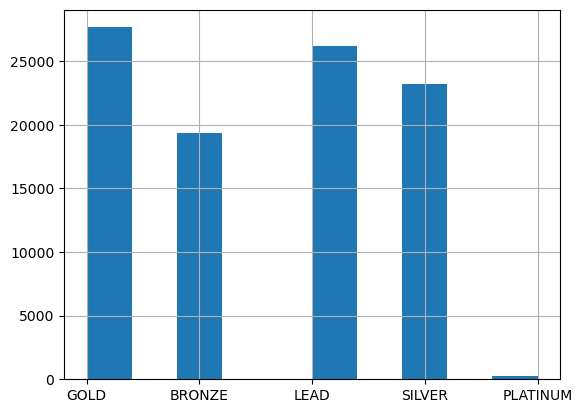

In [23]:
df_results['oRRank'].hist()

In [24]:
df_positions_ready.head()

,depth,oRRank,Parent,Manufacturer,Criticality,Production,EHS,GxP,PID,classCat,process,parentRRank,parentClassCat,schdGrp,pmEHS,pmGMP,pmCAL,costBin,urgentBin,downtimeBin
Object,,,,,,,,,,,,,,,,,,,,
335TANK0360-1-FE-025,3,3,335TANK0360-1-FLOOP-025,1798,2,1,0,1,1,449,5172,0,449,106,0,0,0,0,0,0
066MTPH9500-2,1,0,NaN,954,1,1,0,1,0,455,2319,0,0,106,0,0,0,0,0,0
335COND0340-1-XV-055,3,1,335COND0340-1,221,2,1,0,1,1,328,5171,4,792,106,0,0,0,0,0,0
335COND0340-1-XV-056,3,1,335COND0340-1,221,2,1,0,1,1,328,5171,4,792,106,0,0,0,0,0,0
073FSVS1820-1,2,0,073TANK1820-1,210,3,1,1,0,1,673,2405,4,782,106,1,0,0,0,0,0
